In [19]:
from matplotlib import pyplot as plt

In [20]:
from scipy.stats import multivariate_normal

In [21]:
import ast
import requests
link = "https://bradfordtuckfield.com/emdata.txt"
f = requests.get(link)
allpoints = ast.literal_eval(f.text)

In [22]:
#initial guesses
mean1=[-1,0]
mean2=[0.5,-1]
mean3=[0.5,0.5]
allmeans=[mean1,mean2,mean3]
cov1=[[1,0],[0,1]]
cov2=[[1,0],[0,1]]
cov3=[[1,0],[0,1]]
allvar=[cov1,cov2,cov3]

In [23]:
def classify(allpts,allmns,allvar):
    vars=[]
    for n in range(len(allmns)):
        vars.append(multivariate_normal(mean=allmns[n], cov=allvar[n]))
    classification=[]
    for point in allpts:
        this_classification=-1
        this_pdf=0
        for n in range(len(allmns)):
            if vars[n].pdf(point)>this_pdf:
                this_pdf=vars[n].pdf(point)
                this_classification=n+1
        classification.append(this_classification)
    return classification

In [24]:
theclass=classify(allpoints,allmeans,allvar)

In [25]:
def makeplot(allpoints,theclass,allmeans):
    thecolors=['black']*len(allpoints)
    for idx in range(len(thecolors)):
        if theclass[idx]==2:
            thecolors[idx]='green'
        if theclass[idx]==3:
            thecolors[idx]='yellow'
    allxs=[point[0] for point in allpoints]
    allys=[point[1] for point in allpoints]
    for i in range(len(allpoints)):
        plt.scatter(allxs[i], allys[i],color=thecolors[i])
    for i in range(len(allmeans)):
        plt.plot(allmeans[i][0],allmeans[i][1],'b*', markersize=15)
    plt.axis('equal')
    plt.show()

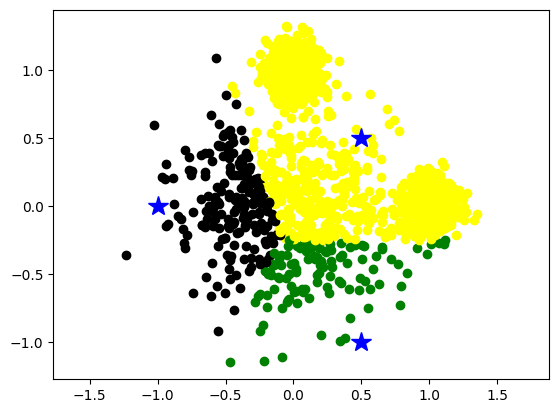

In [26]:
makeplot(allpoints,theclass,allmeans)

In [1]:
import pandas as pd
import numpy as np
interaction=pd.read_csv('https://bradfordtuckfield.com/purchasehistory1.csv')
interaction.set_index("Unnamed: 0", inplace = True)
print(interaction)

            user1  user2  user3  user4  user5
Unnamed: 0                                   
item1           1      1      0      1      1
item2           1      0      1      1      0
item3           1      1      0      1      1
item4           1      0      1      0      1
item5           1      1      0      0      1


In [2]:
interaction_withcounts=interaction.copy()
interaction_withcounts.loc[:,'counts']=interaction_withcounts.sum(axis=1)
interaction_withcounts=interaction_withcounts.sort_values(by='counts',ascending=False)
print(list(interaction_withcounts.index))

['item1', 'item3', 'item2', 'item4', 'item5']


In [3]:
def popularity_based(interaction):
  interaction_withcounts=interaction.copy()
  interaction_withcounts.loc[:,'counts']=interaction_withcounts.sum(axis=1)
  sorted = interaction_withcounts.sort_values(by='counts',ascending=False)
  most_popular=list(sorted.index)
  return(most_popular)

In [4]:
print(popularity_based(interaction))

['item1', 'item3', 'item2', 'item4', 'item5']


In [5]:
print(list(interaction.loc['item1',:]))

[1, 1, 0, 1, 1]


In [6]:
def dot_product(vector1,vector2):
    thedotproduct=np.sum([vector1[k]*vector2[k] for k in range(0,len(vector1))])
    return(thedotproduct)

In [7]:
def vector_norm(vector):
  thenorm=np.sqrt(dot_product(vector,vector))
  return(thenorm)

In [8]:
def cosine_similarity(vector1,vector2):
  thedotproduct=dot_product(vector1,vector2)
  thecosine=thedotproduct/(vector_norm(vector1)*vector_norm(vector2))
  thecosine=np.round(thecosine,4)
  return(thecosine)

In [9]:
import numpy as np
item1=interaction.loc['item1',:]
item3=interaction.loc['item3',:]
print(cosine_similarity(item1,item3))

1.0


In [10]:
item1

user1    1
user2    1
user3    0
user4    1
user5    1
Name: item1, dtype: int64

In [11]:
item3

user1    1
user2    1
user3    0
user4    1
user5    1
Name: item3, dtype: int64

In [13]:
item2=list(interaction.loc['item2',:])
item5=list(interaction.loc['item5',:])
print(cosine_similarity(item2,item5))

0.3333


In [14]:
item2

[1, 0, 1, 1, 0]

In [15]:
item5

[1, 1, 0, 0, 1]

In [16]:
ouritem='item1'
otherrows=[rowname for rowname in interaction.index if rowname!=ouritem]
otheritems=interaction.loc[otherrows,:]
theitem=interaction.loc[ouritem,:]

In [17]:
similarities=[]
for items in otheritems.index:
    similarities.append(cosine_similarity(theitem,otheritems.loc[items,:]))
otheritems['similarities']=similarities
recommendations = list(otheritems.sort_values(by='similarities',ascending=False).index)

In [18]:
print(recommendations)

['item3', 'item5', 'item2', 'item4']


In [19]:
def get_item_recommendations(interaction,itemname):
    otherrows=[rowname for rowname in interaction.index if rowname!=itemname]
    otheritems=interaction.loc[otherrows,:]
    theitem=list(interaction.loc[itemname,:])
    similarities=[]
    for items in otheritems.index:
        similarities.append(cosine_similarity(theitem,list(otheritems.loc[items,:])))
    otheritems['similarities']=similarities
    return list(otheritems.sort_values(by='similarities',ascending=False).index)

In [20]:
user2=interaction.loc[:,'user2']
user5=interaction.loc[:,'user5']
print(cosine_similarity(user2,user5))

0.866


In [21]:
user3=interaction.loc[:,'user3']
user5=interaction.loc[:,'user5']
print(cosine_similarity(user3,user5))

0.3536


In [22]:
def get_similar_users(interaction,username):
    othercolumns=[columnname for columnname in interaction.columns if columnname!=username]
    otherusers=interaction[othercolumns]
    theuser=list(interaction[username])
    similarities=[]
    for users in otherusers.columns:
        similarities.append(cosine_similarity(theuser,list(otherusers.loc[:,users])))
    otherusers.loc['similarities',:]=similarities
    return list(otherusers.sort_values(by='similarities',axis=1,ascending=False).columns)

In [23]:
def get_user_recommendations(interaction,username):
    similar_users=get_similar_users(interaction,username)
    purchase_history=interaction[similar_users[0]]
    purchased=list(purchase_history.loc[purchase_history==1].index)
    purchased2=list(interaction.loc[interaction[username]==1,:].index)
    recs=sorted(list(set(purchased) - set(purchased2)))
    return(recs)

In [25]:
get_user_recommendations(interaction,'user2')

<ipython-input-22-a6e1564abba5>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  otherusers.loc['similarities',:]=similarities


['item4']

In [26]:
import pandas as pd
lastfm = pd.read_csv("https://bradfordtuckfield.com/lastfm-matrix-germany.csv")
print(lastfm.head())

   user  a perfect circle  abba  ac/dc  adam green  aerosmith  afi  air  \
0     1                 0     0      0           0          0    0    0   
1    33                 0     0      0           1          0    0    0   
2    42                 0     0      0           0          0    0    0   
3    51                 0     0      0           0          0    0    0   
4    62                 0     0      0           0          0    0    0   

   alanis morissette  alexisonfire  ...  timbaland  tom waits  tool  \
0                  0             0  ...          0          0     0   
1                  0             0  ...          0          0     0   
2                  0             0  ...          0          0     0   
3                  0             0  ...          0          0     0   
4                  0             0  ...          0          0     0   

   tori amos  travis  trivium  u2  underoath  volbeat  yann tiersen  
0          0       0        0   0          0        

In [27]:
lastfm.drop(['user'],axis=1,inplace=True)

In [28]:
lastfmt=lastfm.T

In [29]:
print(lastfmt.shape)

(285, 1257)


In [30]:
get_item_recommendations(lastfmt,'abba')[0:10]

['madonna',
 'robbie williams',
 'elvis presley',
 'michael jackson',
 'queen',
 'the beatles',
 'kelly clarkson',
 'groove coverage',
 'duffy',
 'mika']

In [31]:
print(get_user_recommendations(lastfmt,0)[0:3])

<ipython-input-8-098bba26fa1a>:3: RuntimeWarning: invalid value encountered in scalar divide
  thecosine=thedotproduct/(vector_norm(vector1)*vector_norm(vector2))


['billy talent', 'bob marley', 'die toten hosen']


<ipython-input-22-a6e1564abba5>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  otherusers.loc['similarities',:]=similarities
